In [1]:
%pylab inline
try:
    reload(galpy.df_src.streamgapdf)
    reload(galpy.df_src.streamgapdf.galpy.df_src.streamdf)
except NameError:
    import galpy.df_src.streamgapdf
import os, os.path
import copy
from scipy import interpolate
from galpy.orbit import Orbit
from galpy.potential import LogarithmicHaloPotential
from galpy.actionAngle import actionAngleIsochroneApprox, estimateBIsochrone
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_coords, bovy_conversion #for unit conversions

Populating the interactive namespace from numpy and matplotlib


# Exploration of the simulation in action-angle coordinates

We've calculated the actions, frequencies, and angles using the calc_actions.py code; load them for the unperturbed stream

In [2]:
aaid1= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed_aA1.txt'),
                     delimiter=',')
aaid2= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed_aA2.txt'),
                     delimiter=',')
aaid= numpy.vstack((aaid1,aaid2))
aaid= aaid[numpy.argsort(aaid[:,9])]

In [3]:
freqs_unp= aaid[:,3:6]
angles_unp= aaid[:,6:9]

We set up the same galpy model as in the other notebook

In [4]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
R0, V0= 8., 220.

In [5]:
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out

In [6]:
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]])

In [7]:
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [8]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper

In [9]:
sdfl_unp_peri= streamdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                        leading=False,nTrackChunks=26,nTrackIterations=1,
                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                        Vnorm=V0,Rnorm=R0)

We also set up a stream instance with ``sigMeanOffset=4.5``, which seems to give a better fit to the stream (see below)

In [10]:
sdfl_unp_peri_sm45= streamdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                            leading=False,nTrackChunks=26,nTrackIterations=1,
                             sigMeanOffset=4.5,
                            tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                            Vnorm=V0,Rnorm=R0)

Let's calculate the parallell direction from the data and compare it to that in the model

In [11]:
# Only use particles not bound to the progenitor
thetar= angles_unp[:,0]
thetar= (numpy.pi+(thetar-numpy.median(thetar))) % (2.*numpy.pi)
indx= numpy.fabs(thetar-numpy.pi) > (5.*numpy.median(numpy.fabs(thetar-numpy.median(thetar))))
Or= freqs_unp[:,0]
Op= freqs_unp[:,1]
Oz= freqs_unp[:,2]
dOr= Or[indx]-numpy.median(Or)
dOp= Op[indx]-numpy.median(Op)
dOz= Oz[indx]-numpy.median(Oz)
dO= numpy.vstack((dOr,dOp,dOz))*bovy_conversion.freq_in_Gyr(220.,8.)
dO4dir= copy.copy(dO)
dO4dir[:,dO4dir[:,0] < 0.]*= -1.
dOdir= numpy.median(dO4dir,axis=1)
dOdir/= numpy.sqrt(numpy.sum(dOdir**2.))
dO1d= numpy.dot(dOdir,dO)

In [12]:
print dOdir, sdfl_unp_peri._dsigomeanProgDirection, (dOdir-sdfl_unp_peri._dsigomeanProgDirection)/numpy.fabs(dOdir)

[-0.70156434 -0.47947009 -0.5271773 ] [-0.6936491  -0.48167747 -0.53557234] [-0.01128226  0.00460379  0.0159245 ]


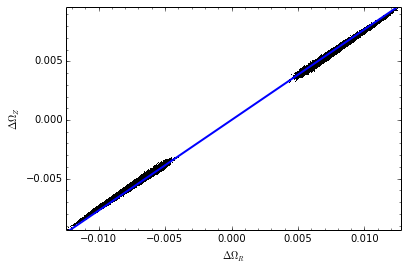

In [13]:
bovy_plot.bovy_plot(dOr,dOz,'k,',
                    xlabel=r'$\Delta \Omega_R$',ylabel=r'$\Delta \Omega_Z$',
                    zorder=0)
xs= numpy.linspace(numpy.amin(dOr),numpy.amax(dOr),2)
ys= sdfl_unp_peri._dsigomeanProgDirection[2]/sdfl_unp_peri._dsigomeanProgDirection[0]*xs
bovy_plot.bovy_plot(xs,ys,'b-',overplot=True,zorder=1,lw=2.)

Well, that worked remarkably well! Let's now look at how well we model the distribution of parallel frequencies

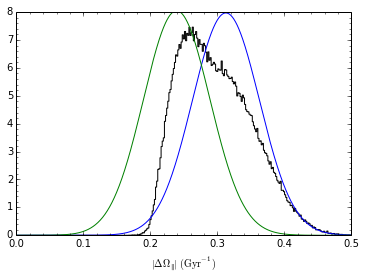

In [14]:
dum= bovy_plot.bovy_hist(numpy.fabs(dO1d),
                        xrange=[0.,0.5],normed=True,
                       histtype='step',color='k',bins=301,zorder=0,
                        xlabel=r'$|\Delta \Omega_\parallel|\,(\mathrm{Gyr}^{-1})$')
xs= numpy.linspace(0.,0.5,1001)
ys= xs*numpy.exp(-0.5*(xs/bovy_conversion.freq_in_Gyr(V0,R0)-sdfl_unp_peri._meandO)**2./sdfl_unp_peri._sortedSigOEig[2])
ys/= numpy.sum(ys)*(xs[1]-xs[0])
bovy_plot.bovy_plot(xs,ys,'b-',overplot=True,zorder=1)
# same for sm5
xs= numpy.linspace(0.,0.5,1001)
ys= xs*numpy.exp(-0.5*(xs/bovy_conversion.freq_in_Gyr(V0,R0)-sdfl_unp_peri_sm45._meandO)**2./sdfl_unp_peri_sm45._sortedSigOEig[2])
ys/= numpy.sum(ys)*(xs[1]-xs[0])
bovy_plot.bovy_plot(xs,ys,'g-',overplot=True,zorder=1)

In [15]:
print numpy.mean(numpy.fabs(dO1d)), numpy.sum(ys*xs)/numpy.sum(ys), (numpy.mean(numpy.fabs(dO1d))-numpy.sum(ys*xs)/numpy.sum(ys))/numpy.mean(numpy.fabs(dO1d))

0.297555135223 0.2396252308 0.194686286892


Let's also calculate the parallel angles and look at parallel frequency vs. parallel angle

In [16]:
ar= angles_unp[:,0]
ap= angles_unp[:,1]
az= angles_unp[:,2]
# Patch them up by hand ...
indx1= (ar > 4.5)*(ar < 7.)*(az > 1.)*(az < 3.)
ar[indx1]-= 2.*numpy.pi
ap[indx1]-= 2.*numpy.pi
indx2= (ar > 4.5)*(ar < 7.)*(az < 1.)
az[indx2]+= 2.*numpy.pi
indx3= (ap > 4.5)*(ar < 2.5)
ap[indx3]-= 2.*numpy.pi
dar= ar[indx]-numpy.median(ar)
dap= ap[indx]-numpy.median(ap)
daz= az[indx]-numpy.median(az)
da= numpy.vstack((dar,dap,daz))
da1d= numpy.dot(dOdir,da)

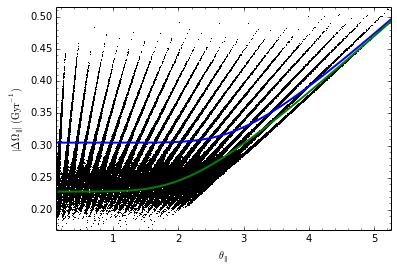

In [17]:
bovy_plot.bovy_plot(numpy.fabs(da1d),numpy.fabs(dO1d),'k,',
                    zorder=0,
                   xlabel=r'$\theta_\parallel$',
                   ylabel=r'$|\Delta \Omega_\parallel|\,(\mathrm{Gyr}^{-1})$')
xs= numpy.linspace(0.,6.,101)
ys= numpy.array([sdfl_unp_peri.meanOmega(x,oned=True) for x in xs])*bovy_conversion.freq_in_Gyr(V0,R0)
bovy_plot.bovy_plot(xs,ys,'b-',overplot=True,zorder=1,lw=2.)
# Same for sm5
ys= numpy.array([sdfl_unp_peri_sm45.meanOmega(x,oned=True) for x in xs])*bovy_conversion.freq_in_Gyr(V0,R0)
bovy_plot.bovy_plot(xs,ys,'g-',overplot=True,zorder=1,lw=2.)

How do the frequencies and angles of the progenitor compare in the simulation and the model?

In [20]:
print numpy.median(Or), numpy.median(Op), numpy.median(Oz)
print sdfl_unp_peri_sm45._progenitor_Omega
print (numpy.hstack((numpy.median(Or), numpy.median(Op), numpy.median(Oz)))-sdfl_unp_peri_sm45._progenitor_Omega)/sdfl_unp_peri_sm45._progenitor_Omega

0.509437038134 0.348684769815 0.382901584749
[ 0.5094622   0.34870253  0.38292221]
[ -4.93877896e-05  -5.09391639e-05  -5.38684346e-05]


In [21]:
print numpy.median(ar), numpy.median(ap), numpy.median(az)
print sdfl_unp_peri_sm45._progenitor_angle
print (numpy.hstack((numpy.median(ar), numpy.median(ap), numpy.median(az)))-sdfl_unp_peri_sm45._progenitor_angle)/sdfl_unp_peri_sm45._progenitor_angle

1.9522975979 -0.11907799484 4.07880813942
[ 1.95732492  6.16753224  4.08233059]
[ -2.56846768e-03  -1.01930724e+00  -8.62852054e-04]
